# Avance de proyecto 1: Sistema de recomendación
## Maestría en inteligencia artificial aplicada: Análisis de grandes volúmenes de datos


Equipo:
- Abraham Cabanzo Jimenez A01794355
- Ignacio Antonio Ruiz Guerra A00889972
- Moisés Díaz Malagón A01208580


In [2]:
# si se utiliza google colab
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("drive/My Drive/CloudTeamMNA")

Mounted at /content/drive


## Exploración inicial y análisis del conjunto de datos

In [3]:
# importamos librerias que necesitaremos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv("./imdb_top_1000.csv")

In [5]:
# Comenzamos el análisis exploratorio observando algunos de los datos
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [6]:
df.shape # observamos que tiene 1000 registros y 16 columnas (o features)

(1000, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


Se observa que las columnas de texto son:
- Poster_Link (texto)
- Series_Title (texto, se puede considerar id único)
- Overview (puede ser util para NLP)

Las columnas con categorías:
- Released_Year
- Certificate
- Genre (puede contener múltiples géneros separados por comma)
- Director (se considerará como categórica)
- Star1 a Star4 (se considerarán como categóricas)


Las columnas con datos numéricas son:
- Runtime (requiere preprocesamiento, porque inicialmente es texto)
- IMBD_Rating
- Meta_score
- No_of_Votes
- Gross (requiere preprocesamiento porque está como texto separando miles con coma)




In [8]:
# observamos porcentaje de valores faltantes
df.isna().mean()*100

Poster_Link       0.0
Series_Title      0.0
Released_Year     0.0
Certificate      10.1
Runtime           0.0
Genre             0.0
IMDB_Rating       0.0
Overview          0.0
Meta_score       15.7
Director          0.0
Star1             0.0
Star2             0.0
Star3             0.0
Star4             0.0
No_of_Votes       0.0
Gross            16.9
dtype: float64

Se observa que existen datos faltantes en Certificate Meta_score y Gross (ganancias de la película). Hemos decidido inicialmente no hacer imputación de datos y no utilizar las columnas Certificate, Meta_score. Sin embargo conservaremos Gross pues creemos que puede aportar un gran valor informativo de los gustos de las personas.

### Preprocesamiento

In [9]:
import re

# Convertiremos gross de texto a cantidad numérica flotante
df['Gross'] = df['Gross'].str.replace(',','').astype('float64')

# Convertimos runtime de texto a cantidad numérica entera representando minutos
df['Runtime'] = df['Runtime'].apply(lambda x: int(re.sub(r'\w*min$', '', x)))



### Análisis de variables numéricas

In [10]:
# obtenemos estadísticos descriptivos de las variables numéricas
num_columns = [
    'Runtime',
    'IMDB_Rating',
    'Meta_score',
    'No_of_Votes',
    'Gross'
]

df[num_columns].describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


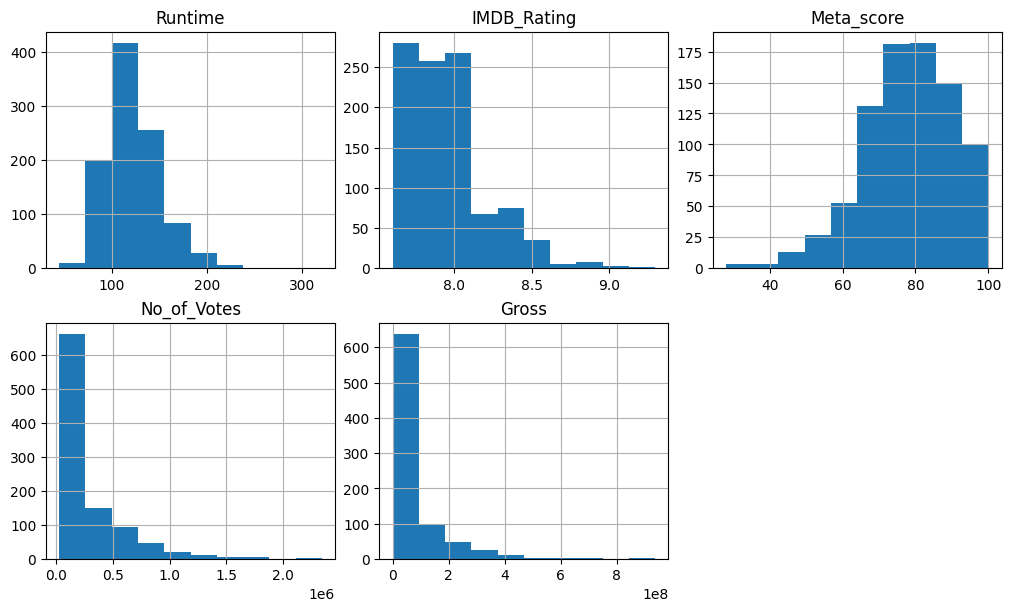

In [11]:

def make_hist_plots(df, column_names, bins=10):
  plt.figure(figsize=(10,6), constrained_layout=True)
  for idx,column_name in enumerate(column_names):
    ax = plt.subplot(2,3,idx+1)
    df[column_name].hist(bins=bins)
    ax.set_title(column_name)
  plt.show()

make_hist_plots(df, num_columns, 10)



Se observa de los histogramas lo siguiente:
- Runtime está sesgado a la derecha, la mayoría de las películas duran alredeodr de 100 minutos.
- IMDB_Rating se encuentra sesgado a la derecha.
- Meta_score tiene un sesgo a la izquierda aunque en menor grado, se observa más normal.
- No_of_Votes se observa con un claro sesgo a la derecha al igual que el volumen de ventas generado (Gross)

### Análisis de variables categóricas

In [12]:
'''
Veamos ahora la cuenta, número de valores únicos, la moda de las variables
categóricas. Recordemos que no se consideran las siguietnes variables aunque sean
texto:
- Poster_Link: pues es único en cada caso, similar a un identificador.
- Series_Title: de igual forma es único y es un identificador.
- Overview: es texto plano, puede ser útil para NLP.

Consideraremos:
- Released_Year
- Certificate
- Genre
- Director
- Star1 a Star4: protagonistas
'''


categorical_columns = [
    'Released_Year',
    'Certificate',
    'Genre',
    'Director',
    'Star1',
    'Star2',
    'Star3',
    'Star4',
]

df[categorical_columns].describe()

,Released_Year,Certificate,Genre,Director,Star1,Star2,Star3,Star4
count,1000,899,1000,1000,1000,1000,1000,1000
unique,100,16,202,548,660,841,891,939
top,2014,U,Drama,Alfred Hitchcock,Tom Hanks,Emma Watson,Rupert Grint,Michael Caine
freq,32,234,85,14,12,7,5,4


Analizaremos el conteo de las variables categóricas: Certificate, Genre, Director y Stars1 a 4.

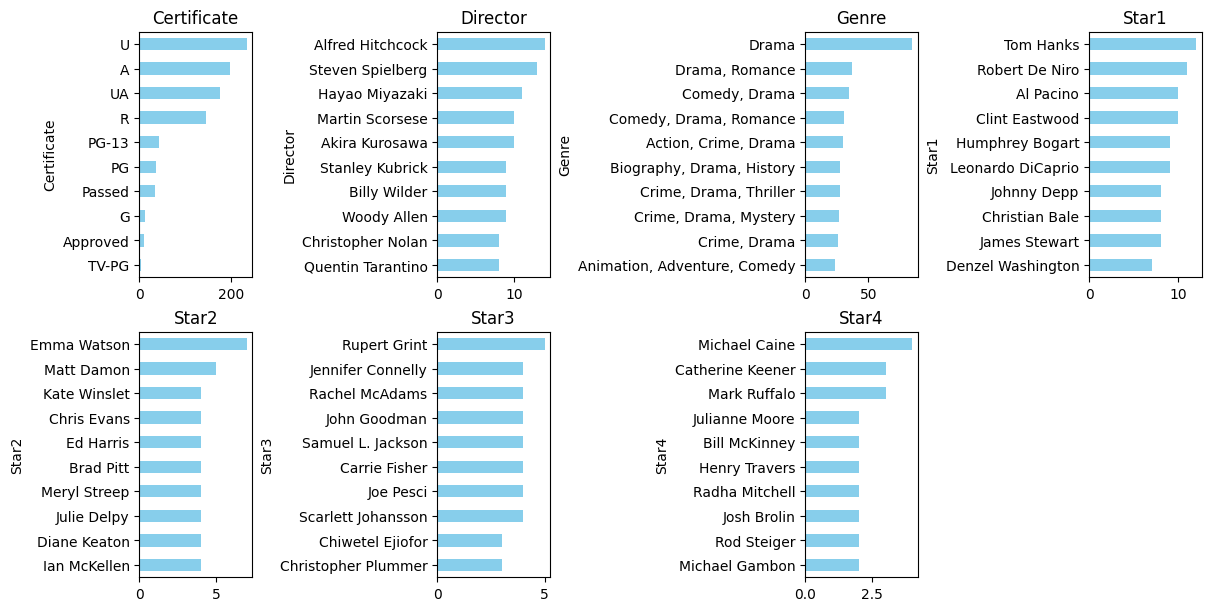

In [13]:

def make_count_plot(df, column_names, bins=10):
  plt.figure(figsize=(12,6), constrained_layout=True)
  for idx,column_name in enumerate(column_names):
    ax = plt.subplot(2,4,idx+1)
    cer_counts = df[column_name].value_counts().sort_values(ascending=False)
    cer_counts.iloc[0:10].plot(kind='barh', color='skyblue')
    ax.invert_yaxis()
    ax.set_title(column_name)
  plt.show()

make_count_plot(df, ['Certificate', 'Director', 'Genre', 'Star1', 'Star2', 'Star3', 'Star4'])


In [14]:
# revisamos ahora la frecuencia y cantidad de valores únicos
for column_name in categorical_columns:
  print("-------------------------------------------")
  print(df[column_name].value_counts().sort_values(ascending=False))
  print("Valores únicos: ", df[column_name].nunique())

-------------------------------------------
Released_Year
2014    32
2004    31
2009    29
2016    28
2013    28
        ..
1926     1
1936     1
1924     1
1921     1
PG       1
Name: count, Length: 100, dtype: int64
Valores únicos:  100
-------------------------------------------
Certificate
U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: count, dtype: int64
Valores únicos:  16
-------------------------------------------
Genre
Drama                        85
Drama, Romance               37
Comedy, Drama                35
Comedy, Drama, Romance       31
Action, Crime, Drama         30
                             ..
Action, Adventure, Family     1
Biography, Drama, Romance     1
Adventure, History, War       1
Drama, History, Music         1
Adventure, Comedy, War        1
N

Finalmente analizaremos los años de lanzamiento.

In [15]:
import seaborn as sns

# Estadísticas descriptivas básicas
df_year_as_date = pd.to_datetime(df['Released_Year'], errors='coerce')
year_stats = df_year_as_date.describe()

print("Estadísticas descriptivas de los años de lanzamiento:\n", year_stats)

Estadísticas descriptivas de los años de lanzamiento:
 count                              999
mean     1991-03-21 11:00:10.810810880
min                1920-01-01 00:00:00
25%                1976-01-01 00:00:00
50%                1999-01-01 00:00:00
75%                2009-01-01 00:00:00
max                2020-01-01 00:00:00
Name: Released_Year, dtype: object


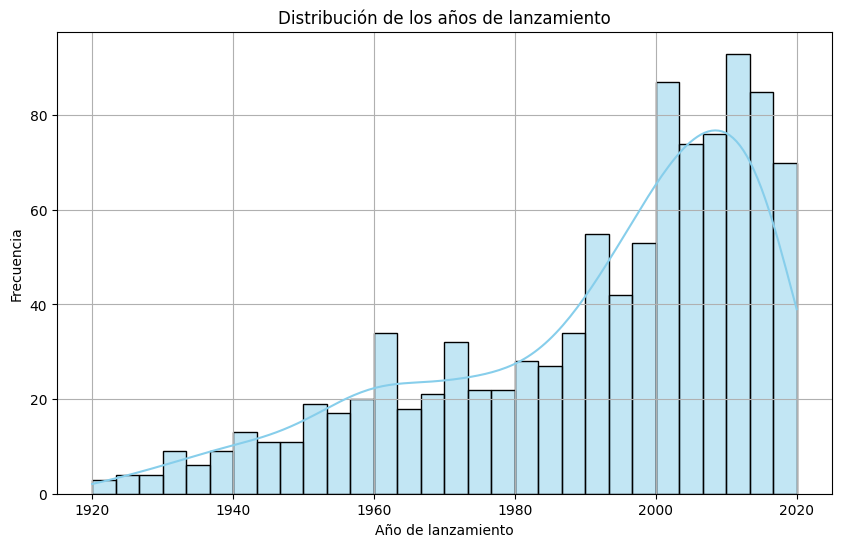

In [16]:

# Histograma de los años de lanzamiento
plt.figure(figsize=(10, 6))
sns.histplot(df_year_as_date, bins=30, kde=True, color='skyblue')
plt.title('Distribución de los años de lanzamiento')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



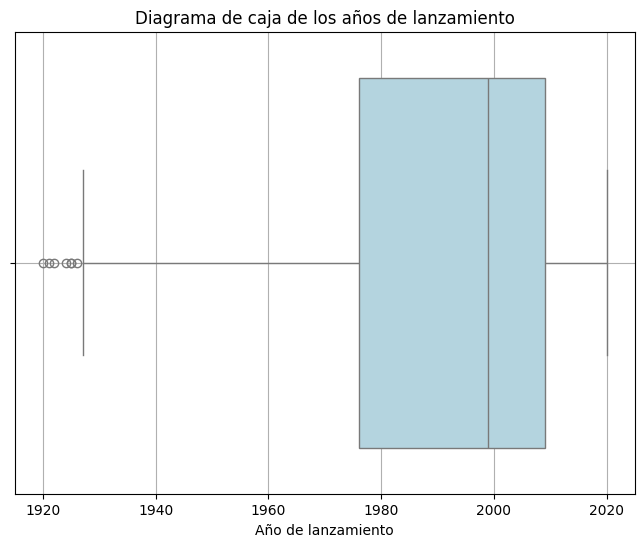

In [17]:
# Diagrama de caja (boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_year_as_date, color='lightblue')
plt.title('Diagrama de caja de los años de lanzamiento')
plt.xlabel('Año de lanzamiento')
plt.grid(True)
plt.show()

Observamos que la mayoría de películas (el 50%) se encuentra en el rango de 1976 a 2009. Vemos algunos outliers en el caso de películas muy antiguas. Y no vemos datos por encima del 2020 lo que indica que este set de datos no está actualizado después de esta fecha.

In [18]:

# Contar la cantidad de enlaces, se confirma que son enlaces únicos y por lo
# son como identificadores, no aportan información adicional
print("Cantidad de enlaces únicos:", df['Poster_Link'].nunique() )


Cantidad de enlaces únicos: 1000


## 2da parte preprocesamiento

In [23]:
from sklearn.impute import SimpleImputer


# Imputación de datos faltantes utilizando el promedio de las calificaciones
imputer = SimpleImputer(strategy='mean')
df['Meta_score'] = imputer.fit_transform(df['Meta_score'].values.reshape(-1, 1))

# Imputación de datos faltantes utilizando la media de los ingresos recibidos,
# pues la distribución de Gross tiene un sesgo fuerte a la derecha.
imputer = SimpleImputer(strategy='median')
df['Gross'] = imputer.fit_transform(df['Gross'].values.reshape(-1, 1))


In [24]:
# observamos que ahora solo tenemos datos faltantes en certificate,
# como es probable que no utilizemos esta columna por el momento lo dejaremos así
df.isna().mean()*100

Poster_Link       0.0
Series_Title      0.0
Released_Year     0.0
Certificate      10.1
Runtime           0.0
Genre             0.0
IMDB_Rating       0.0
Overview          0.0
Meta_score        0.0
Director          0.0
Star1             0.0
Star2             0.0
Star3             0.0
Star4             0.0
No_of_Votes       0.0
Gross             0.0
dtype: float64

In [49]:

# Codificación de variables categóricas

'''
Podemos observar que tenemos 202 combinaciones diferentes de géneros.
Por tal razón se ha decidido utilizar binary encoding en lugar de onehot para este caso.

Para director y las estrellas tenemos más de 100 valores únicos distintos,
por ello también utilizaremos binary encoding para codificarlas.

Para año utilizaremos ordinal encoding, pues nos permite conservar la relación
ascendente del tiempo.

Por otro lado para Certificado tenemos 16 variantes, por lo tanto utilizaremos
onehot encoding.

'''
# !pip install category_encoders
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders.binary import BinaryEncoder

genre_encoder = BinaryEncoder()
release_year_encoder = BinaryEncoder()
director_encoder = BinaryEncoder()
star1_encoder = BinaryEncoder()
star2_encoder = BinaryEncoder()
star3_encoder = BinaryEncoder()
star4_encoder = BinaryEncoder()
certificate_encoder = OneHotEncoder(sparse=False, drop='first')

encoded_genre = genre_encoder.fit_transform(df['Genre'])
encoded_director = director_encoder.fit_transform(df['Director'])
encoded_star1 = star1_encoder.fit_transform(df['Star1'])
encoded_star2 = star2_encoder.fit_transform(df['Star2'])
encoded_star3 = star3_encoder.fit_transform(df['Star3'])
encoded_star4 = star4_encoder.fit_transform(df['Star4'])

encoded_release_year = release_year_encoder.fit_transform(df[['Released_Year']])
encoded_release_year_column_names = release_year_encoder.get_feature_names_out(['Released_Year'])
encoded_release_year = pd.DataFrame(encoded_release_year, columns=encoded_release_year_column_names, index=df.index)

encoded_certificate = certificate_encoder.fit_transform(df[['Certificate']])
encoded_certificate_column_names = certificate_encoder.get_feature_names_out(['Certificate'])
encoded_certificate = pd.DataFrame(encoded_certificate, columns=encoded_certificate_column_names, index=df.index)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [56]:

'''
Finalmente juntamos en un solo dataframe los datos preprocesados.
Es importante notar lo siguiente:

- Poster_Link: se puede utilizar en algorimos de procesamiento de imagen
- Series_Title: es un identificador, lo mantenemos como es. Puede ser util para técnicas de NLP
- Runtime: es el tiempo en minutos de duración
- IMDB_Rating: es la calificación de la película en el sitio IMDB
- Overview: se puede utilizar para ténicas de NLP
- Meta_score: es flotante y ya puede utilizarse en algún algoritmo
- No_of_Votes: es entero y ya está listo para usarse
- Gross: es flotante y está listo para usarse.
- Genre
'''

final_df = df.copy()

# Nótese que conservaremos las columnas originales pues para técnicas de NLP seguiremos utilizandolas
final_df = pd.concat([final_df, encoded_genre, encoded_certificate, encoded_director, encoded_star1, encoded_star2, encoded_star3, encoded_star4, encoded_release_year], axis=1)



In [57]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 97 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Poster_Link           1000 non-null   object 
 1   Series_Title          1000 non-null   object 
 2   Released_Year         1000 non-null   object 
 3   Certificate           899 non-null    object 
 4   Runtime               1000 non-null   int64  
 5   Genre                 1000 non-null   object 
 6   IMDB_Rating           1000 non-null   float64
 7   Overview              1000 non-null   object 
 8   Meta_score            1000 non-null   float64
 9   Director              1000 non-null   object 
 10  Star1                 1000 non-null   object 
 11  Star2                 1000 non-null   object 
 12  Star3                 1000 non-null   object 
 13  Star4                 1000 non-null   object 
 14  No_of_Votes           1000 non-null   int64  
 15  Gross                 

## Sistema de recomendación basado en contenido. Utilizando técnicas de NLP

In [63]:
# Content-based recommendation system

'''
Para este ejercicio haremos uso de técnicas de NLP donde podemos utilizar el texto plano como tal.
'''

columns = ['Series_Title', 'Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']
content = final_df[columns].copy()

# concatenamos los textos, convertimos todo a minúsculas
content['concatenated'] = content['Series_Title'] + " " + content['Genre'] + " " + content['Director'] + " " + content['Star1'] + " " + content['Star2'] + " " + content['Star3'] + " " + content['Star4']


In [92]:
# removemos stop words de ingles (palabras que no aportan contenido tan valioso o que son muy comunes)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


stopwords = stopwords.words('english')

def generate_sentences(doc):
  '''
  El preprocesamiento a utilizar consiste en conservar únicamente caracteres alfabéticos, eliminando
  signos de puntuación, caracteres especiales y números.

  Solamente consideremos palabras (tokens) con longitud mayor a un caracter.

  Convertiremos todo a minúsculas.

  Eliminaremos del texto los stopwords del diccionario de stop words de la librería NLTK en inglés.

  '''
  words = re.sub(r'[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]', ' ', doc)
  words = re.sub(r'\s{2,}', ' ', words.strip())
  words = words.lower().split()
  tokens = [ w for w in words if w not in stopwords]
  return " ".join(tokens)


sentences = [generate_sentences(x) for x in content['concatenated']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
print(content['concatenated'].iloc[0:2])
sentences[0:2] # se puede observar todo el preprocesamiento aplicado en acción

0    The Shawshank Redemption Drama Frank Darabont ...
1    The Godfather Crime, Drama Francis Ford Coppol...
Name: concatenated, dtype: object


['shawshank redemption drama frank darabont tim robbins morgan freeman bob gunton william sadler',
 'godfather crime drama francis ford coppola marlon brando al pacino james caan diane keaton']

In [102]:
'''
Utilizaremos un vectorizador de tipo TF-IDF, que nos permite convertir cada palabra de un enunciado en una lista
de números. La forma de convertirlos consiste en una multiplicación de dos factores:
- La frecuencia de la palabra en todos los documentos.
- La relación de en cuántas oraciones aparece una palabra vs cuantas oraciones tenemos (1000)
'''

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer()
tfidf_matrix = tfidfvectorizer.fit_transform(sentences)


In [105]:
tfidf_matrix.shape
# del tamaño de la matriz podemos observar que tenemos 1000 oraciones
# y que nuestro vocabulario es de 5714 palabras distintas (tokens), entonces
# para cada oración tenemos un vector numérico de tamaño 5714 que representa
# la importancia de cada palabra dada en la oración.

(1000, 5714)

In [120]:
# dado que tenemos un vector numérico podemos utilizar la similitud de coseno
# para determinar oraciones similares

from sklearn.metrics.pairwise import linear_kernel
similarity_mtrx = linear_kernel(tfidf_matrix, tfidf_matrix)

In [129]:
# Tomemos como ejemplo una película dada en el dataset, por ejemplo: 'Star Wars'
movies_index = pd.Series(content.index, index=content['Series_Title']).drop_duplicates()
idx = movies_index['Star Wars']
idx # su índice es 29 (oración 29)

29

In [130]:
# obtenemos el vector de similitudes de esa pelicula con todas las otras
similarity_scores = list(enumerate(similarity_mtrx[idx]))
# ordenamos las pel[iculas con base en los scores de similaidad
similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
# podemos observar las 10 películas más similares, omitimos la primera pues es Star Wars
similarity_scores = similarity_scores[1:11]
title_idxs = [i[0] for i in similarity_scores]
content['Series_Title'].iloc[title_idxs]


109        Star Wars: Episode VI - Return of the Jedi
16     Star Wars: Episode V - The Empire Strikes Back
116                                Lawrence of Arabia
304                      The Bridge on the River Kwai
477        Star Wars: Episode VII - The Force Awakens
869                                   The Ladykillers
975                           When Harry Met Sally...
449                          Kind Hearts and Coronets
72                            Raiders of the Lost Ark
663                                      The Fugitive
Name: Series_Title, dtype: object